In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import os 
import random
from tqdm import tqdm 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from typing import List

In [2]:
dataDirectory = 'Dataset'


trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

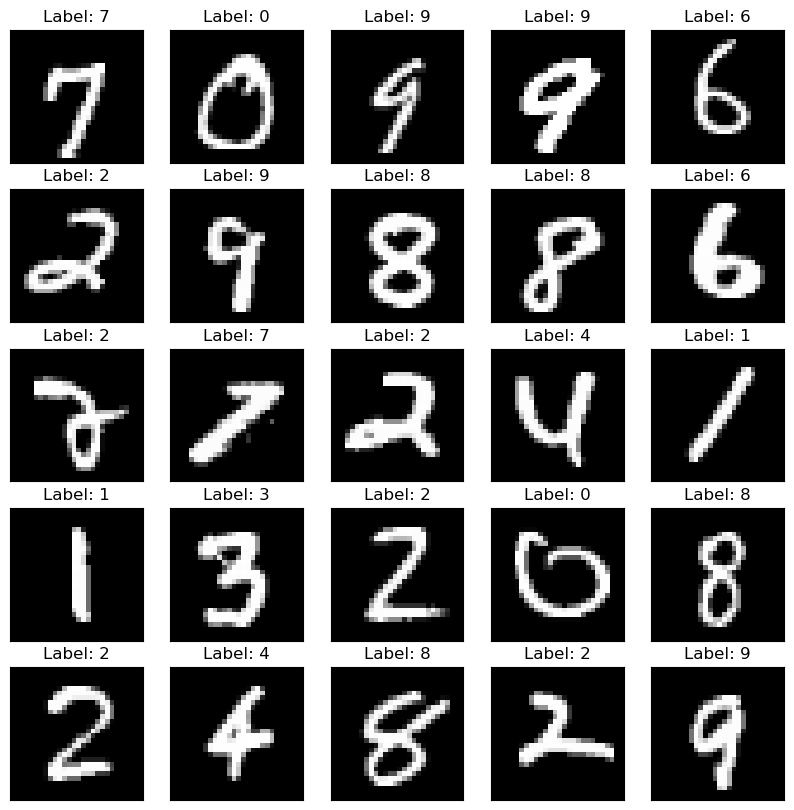

In [3]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [4]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [5]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=256, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [6]:
class VariationalAutoEncoder(nn.Module):

   def __init__(self, latentDim: int, hiddenDim: List = [512, 256], inputDim: int = 784):
      super(VariationalAutoEncoder, self).__init__()

      self.latentDim = latentDim
      self.hiddenDim = hiddenDim
      
      ####--------------ENCODER--------------

      #Initialize the initial dimension to be inputDim
      currentDim = inputDim

      modules = []

      #Define the architecture dynamically
      for h in self.hiddenDim:
         modules.append(
            nn.Sequential(
               nn.Linear(currentDim, h),
               nn.ReLU()
            )
         )
         #update the value of the current dimesion
         currentDim = h

      self.Encoder = nn.Sequential(*modules)

      #Define the latent space 
      self.EncoderMu = nn.Linear(hiddenDim[-1], latentDim)
      self.EncoderSigma = nn.Linear(hiddenDim[-1], latentDim)


      ####--------------DECORDER--------------
      modules = []
      currentDim = latentDim

      #Layers in the decoder are inverted w.r.t encoder
      reversedDim = hiddenDim[::-1]

      for h in reversedDim:
         modules.append(
            nn.Sequential(
               nn.Linear(currentDim, h),
               nn.ReLU()
            )
         )
         currentDim = h

      self.Decoder = nn.Sequential(*modules)
      self.finalLayer = nn.Linear(currentDim, inputDim)

   
   def Encoding(self, x):

      #Flatten the data
      x = x.view(x.size(0), -1)
      x = self.Encoder(x)
      mean, logVar = self.EncoderMu(x), self.EncoderSigma(x)
      return mean, logVar
   
   def Reparametrization(self, mean, logVar):
      std = torch.exp(0.5*logVar)
      epsilon = torch.rand_like(std)
      return mean + std*epsilon
   
   def Decoding(self, z):
      z = self.Decoder(z)
      result = self.finalLayer(z)
      return torch.sigmoid(result)
   
   def forward(self, x):
      mean, logVar = self.Encoding(x)
      z = self.Reparametrization(mean, logVar)
      result = self.Decoding(z)

      return result, z, mean, logVar

In [7]:
model = VariationalAutoEncoder(latentDim = 10, hiddenDim=[30, 40])

In [8]:
loss_fn = torch.nn.MSELoss()

lr = 5e-4
parameToOptimize = [
   {'params': model.parameters()}
]

optim = torch.optim.Adam(parameToOptimize, lr = lr)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

model.to(device)

Selected device: cpu


VariationalAutoEncoder(
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=30, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=30, out_features=40, bias=True)
      (1): ReLU()
    )
  )
  (EncoderMu): Linear(in_features=40, out_features=10, bias=True)
  (EncoderSigma): Linear(in_features=40, out_features=10, bias=True)
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=40, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=40, out_features=30, bias=True)
      (1): ReLU()
    )
  )
  (finalLayer): Linear(in_features=30, out_features=784, bias=True)
)

In [9]:
def Training(model):
   model.train()
   losses = []

   for imageBatch, _ in tqdm(trainDataloader):

      imageBatch = imageBatch.to(device)
      results, z, mean, std = model(imageBatch)

      flat_targets = imageBatch.view(imageBatch.size(0), -1)
      loss = loss_fn(results, flat_targets)

      optim.zero_grad()
      loss.backward()
      optim.step()

      losses.append(loss.detach().cpu().numpy())

   losses = np.mean(losses)

   return losses 

In [10]:
loss = Training(model)

100%|██████████| 235/235 [00:01<00:00, 134.07it/s]


EPOCH 1/10


100%|██████████| 235/235 [00:01<00:00, 136.18it/s]


TRAIN - EPOCH 1/10 - loss: 0.06280914694070816


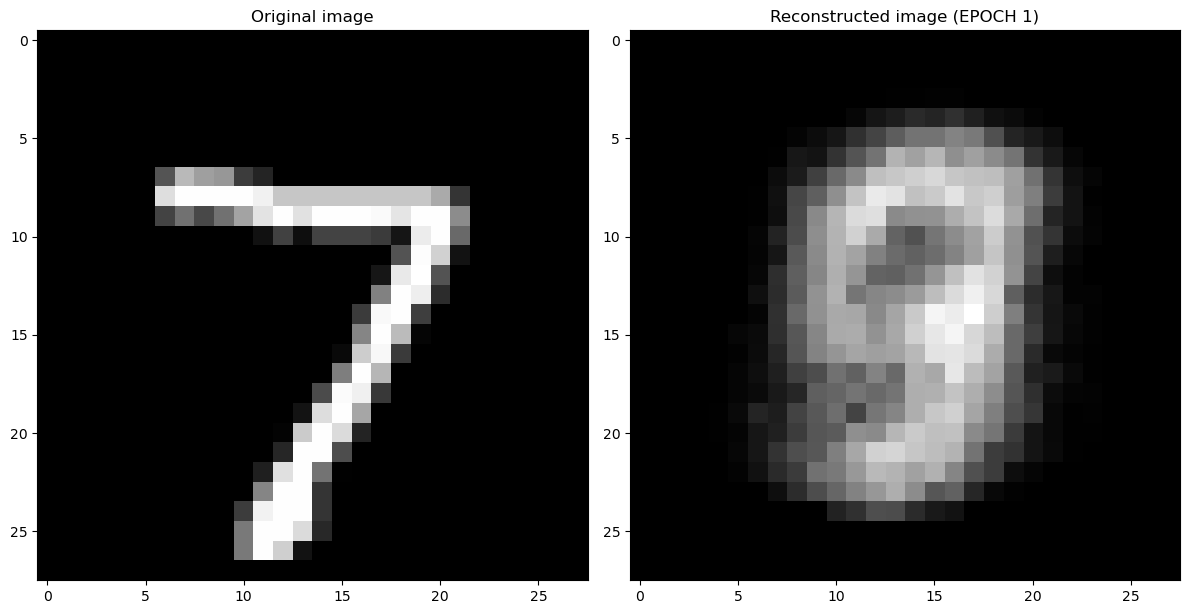

EPOCH 2/10


100%|██████████| 235/235 [00:01<00:00, 145.09it/s]


TRAIN - EPOCH 2/10 - loss: 0.05531582981348038


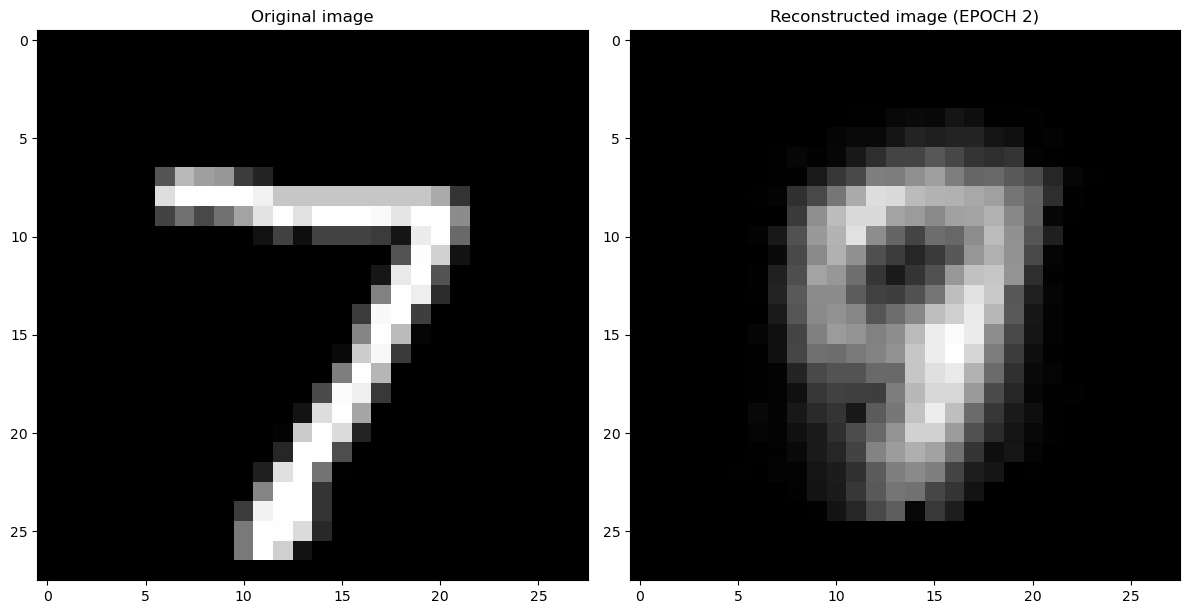

EPOCH 3/10


100%|██████████| 235/235 [00:01<00:00, 143.88it/s]


TRAIN - EPOCH 3/10 - loss: 0.051031239330768585


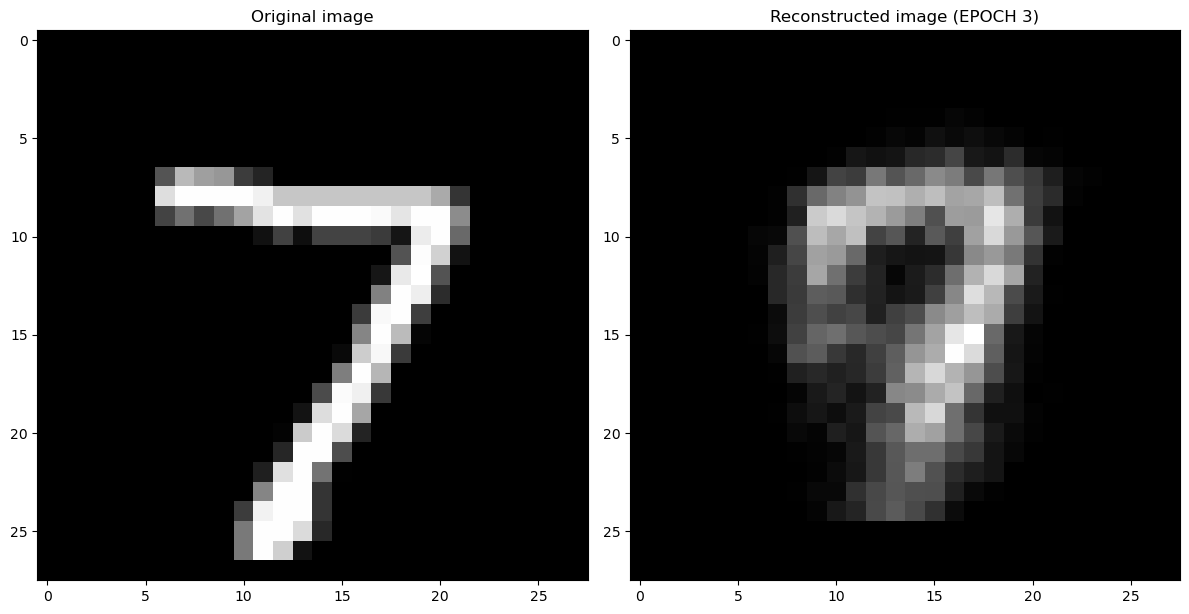

EPOCH 4/10


100%|██████████| 235/235 [00:01<00:00, 140.31it/s]


TRAIN - EPOCH 4/10 - loss: 0.04672360420227051


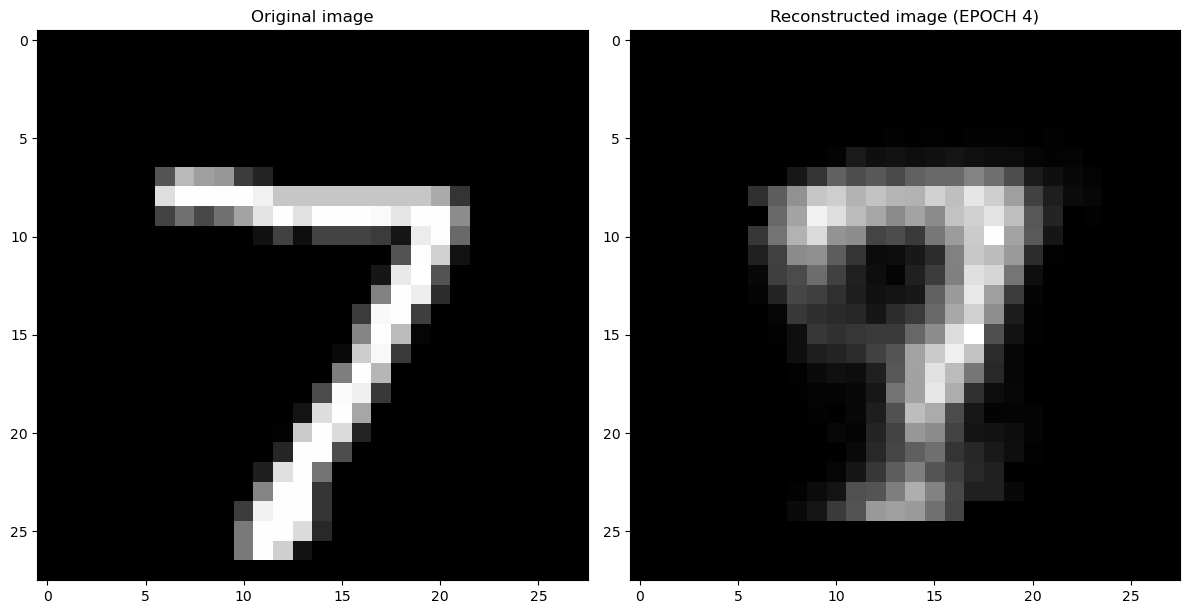

EPOCH 5/10


100%|██████████| 235/235 [00:01<00:00, 143.63it/s]


TRAIN - EPOCH 5/10 - loss: 0.042039066553115845


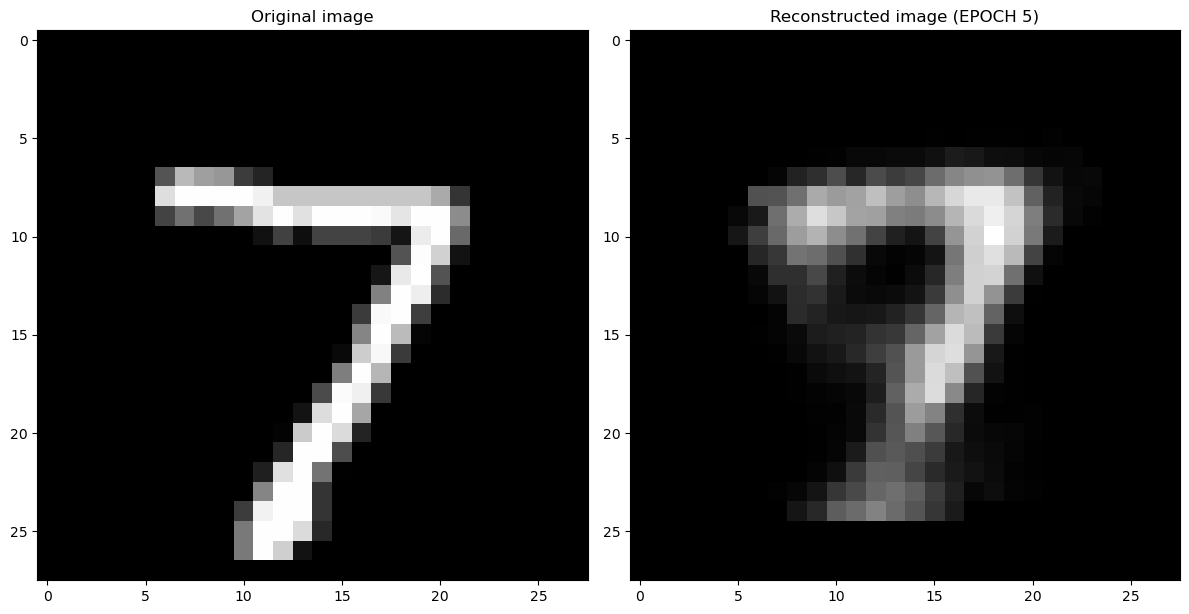

EPOCH 6/10


100%|██████████| 235/235 [00:01<00:00, 140.14it/s]


TRAIN - EPOCH 6/10 - loss: 0.03926646709442139


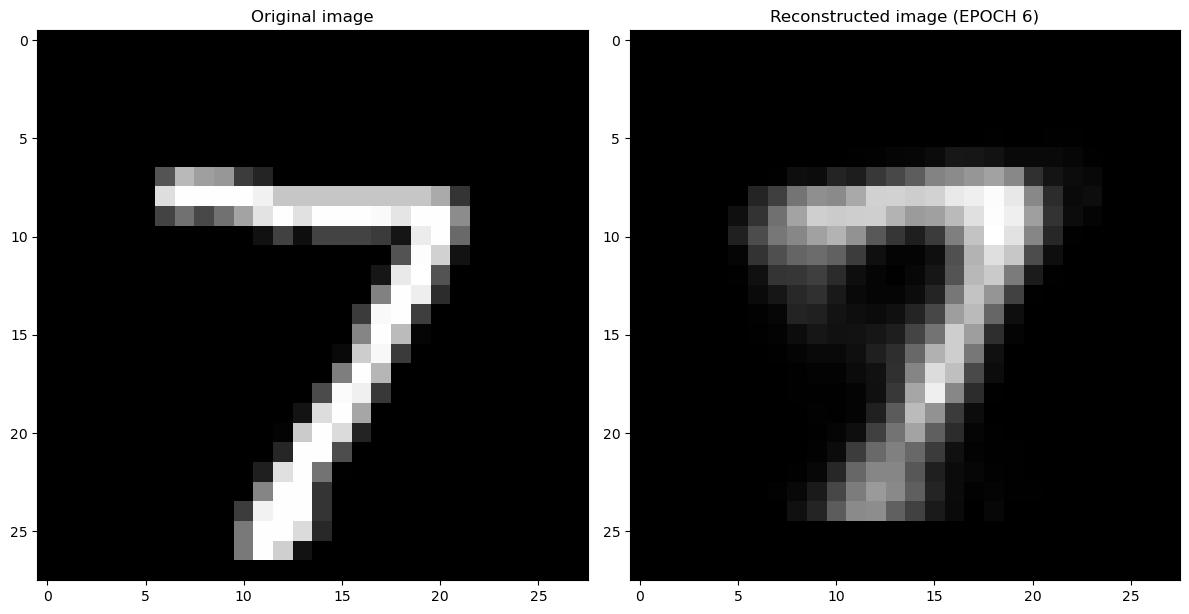

EPOCH 7/10


100%|██████████| 235/235 [00:01<00:00, 139.63it/s]


TRAIN - EPOCH 7/10 - loss: 0.037777990102767944


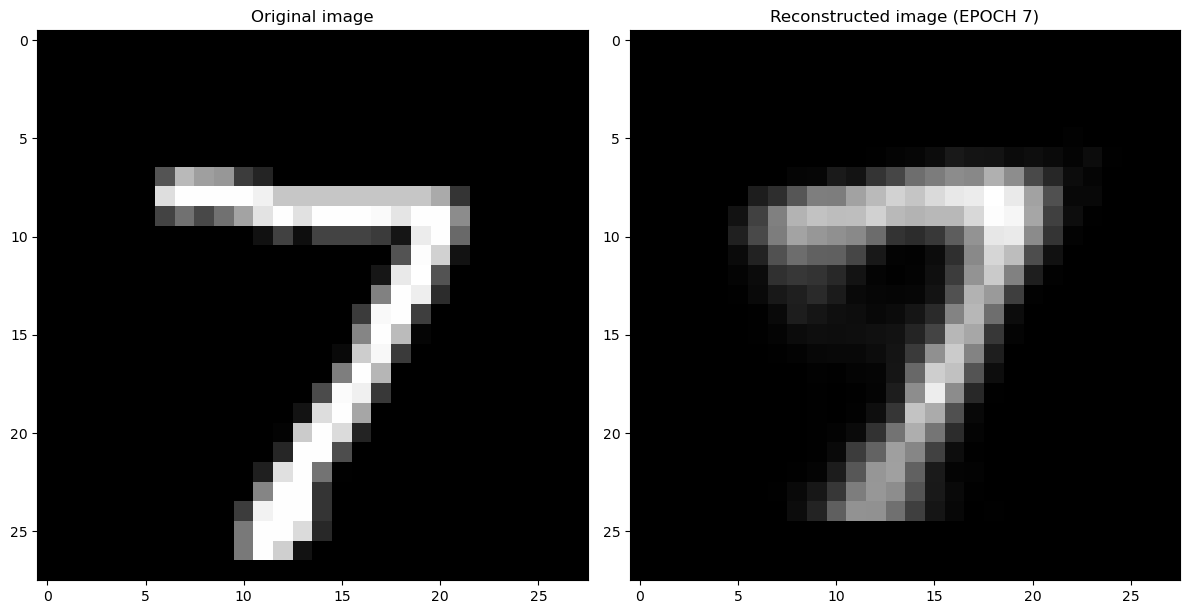

EPOCH 8/10


100%|██████████| 235/235 [00:01<00:00, 140.37it/s]


TRAIN - EPOCH 8/10 - loss: 0.03696064278483391


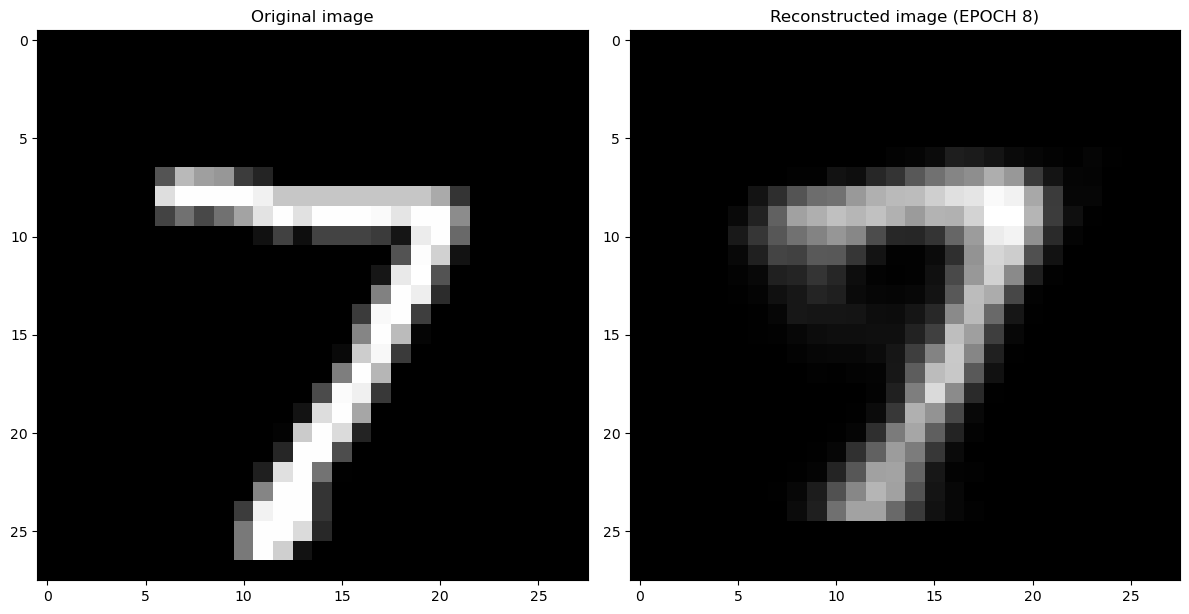

EPOCH 9/10


100%|██████████| 235/235 [00:01<00:00, 143.15it/s]


TRAIN - EPOCH 9/10 - loss: 0.03629957139492035


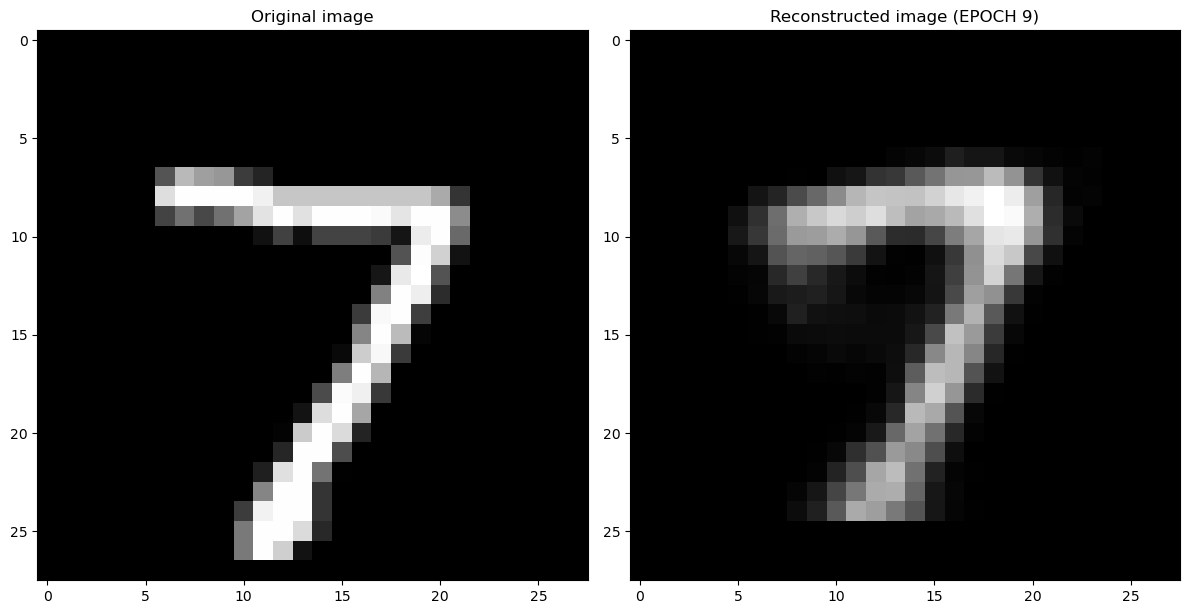

EPOCH 10/10


100%|██████████| 235/235 [00:02<00:00, 106.88it/s]


TRAIN - EPOCH 10/10 - loss: 0.035666219890117645


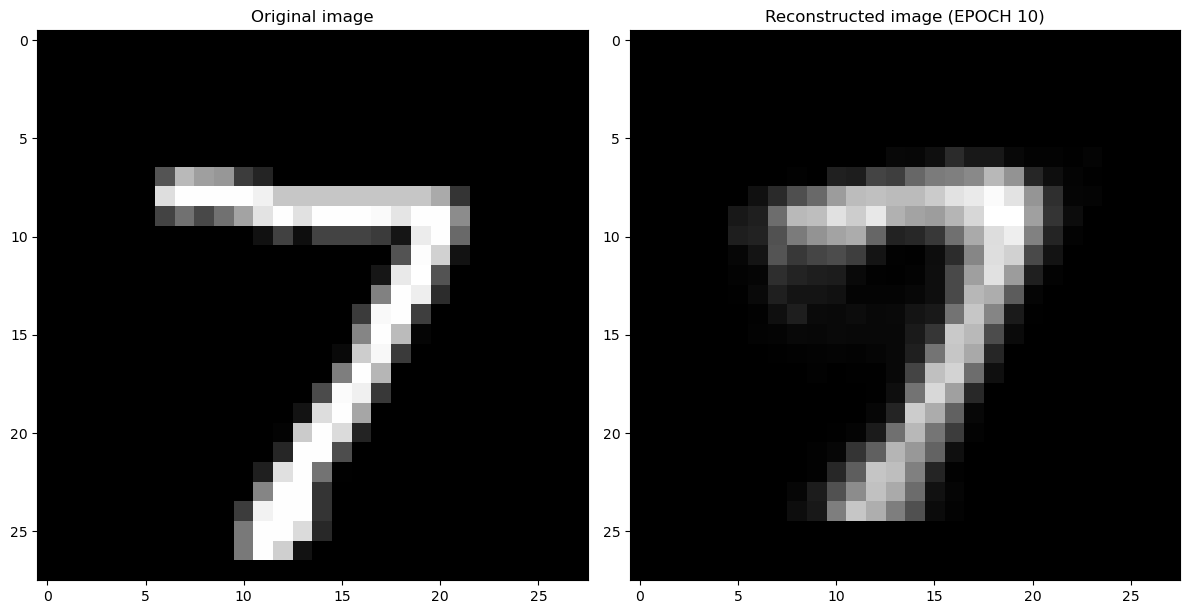

In [11]:
### Training cycle

num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = Training(model)
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss}')

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = testDataset[0][0].unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        rec_img  = model(img)
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img[0].cpu().squeeze().numpy().reshape(28, 28), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    plt.show()
    plt.close()
